# imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, GridSearchCV
from sklearn.base import clone
import matplotlib.pyplot as plt

# General precofniguration

## load data

In [2]:
df_budget = pd.read_csv("budget.csv")
df_contract = pd.read_csv("contract.csv")
df_budget.head()

,university,specialty,points,status
0,Львівський національний університет імені Іван...,81,189.210,1
1,Університет державної фіскальної служби України,81,134.028,1
2,Національний юридичний університет імені Яросл...,81,187.476,1
3,Університет державної фіскальної служби України,81,178.959,1
4,Національний юридичний університет імені Яросл...,81,186.762,1


In [3]:
df_contract.head()

,university,specialty,points,status
0,Львівський національний університет імені Іван...,81,189.210,1
1,Університет державної фіскальної служби України,81,134.028,1
2,Національний юридичний університет імені Яросл...,81,187.476,1
3,Університет державної фіскальної служби України,81,178.959,1
4,Національний юридичний університет імені Яросл...,81,186.762,1


## Prepare data for learning
X - because data are the same for both cases

y_b - labels where we prefer budget applicants

y_c - labels where we prefer contract applicants

In [4]:
def separate_results_from_data(df, budget=True):
    data = df.sample(30000, random_state=2).values
    X, y = data[:, :-1], data[:, -1:]
    y = y.astype("int")
    y = y.ravel()
    return X, y


X, y_b = separate_results_from_data(df_budget)
_, y_c = separate_results_from_data(df_contract)

In [5]:
def get_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    y_train = y_train
    y_test = y_test
    return X_train, X_test, y_train, y_test


X_train, X_test, y_b_train, y_b_test = get_train_test_split(X, y_b)
_, _, y_c_train, y_c_test = get_train_test_split(X, y_c)

In [6]:
np.unique(X[:, 0])

array(['«Закарпатський угорський інститут імені Ференца Ракоці ІІ»',
       '«Київський кооперативний інститут бізнесу і права»',
       'Європейський університет', 'ІТ СТЕП Університет',
       'Івано-Франківська філія Вищого навчального закладу «Відкритий міжнародний університет розвитку людини «Україна»',
       'Івано-Франківський коледж Львівського національного аграрного університету',
       'Івано-Франківський навчально-науковий інститут менеджменту Тернопільського національного економічного університету',
       'Івано-Франківський національний медичний університет',
       'Івано-Франківський національний технічний університет нафти і газу',
       'Ізмаїльський державний гуманітарний університет',
       'Ізмаїльський інститут водного транспорту',
       'Індустріальний коледж Українського державного хіміко-технологічного університету',
       'Індустріальний інститут Державного вищого навчального закладу «Донецький національний технічний університет»',
       'Інститут Упра

In [27]:
pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ohe0", OneHotEncoder(categories=[np.unique(X[:, 0]), np.unique(X[:, 1]),], sparse=False), [0, 1]),
        ],
        remainder="passthrough",
        n_jobs=-1
    ),
    StandardScaler(),
    LogisticRegression(
        C=1,
        max_iter=10,
        penalty="l2",
    )
)

In [28]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_b_train,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5,
    n_jobs=4
)

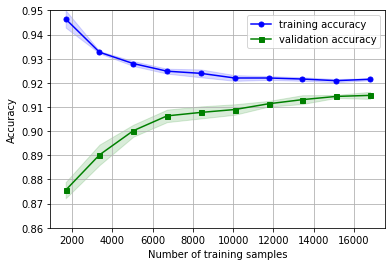

In [29]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean, color="green", marker="s", markersize=5, label="validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.ylim([0.86, 0.95])
plt.legend()
plt.show()

# Learn models

## Check on test samples

In [30]:
pipe_budget_test = clone(pipeline)
pipe_contract_test = clone(pipeline)
pipe_budget_test.fit(X_train, y_b_train)
pipe_contract_test.fit(X_train, y_c_train)

/home/dima/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/dima/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe0',
                                                  OneHotEncoder(categories=[array(['«Закарпатський угорський інститут імені Ференца Ракоці ІІ»',
       '«Київський кооперативний інститут бізнесу і права»',
       'Європейський університет', 'ІТ СТЕП Університет'...
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10,
            

In [31]:
pipe_budget_test.score(X_test, y_b_test)

0.917

In [32]:
pipe_contract_test.score(X_test, y_c_test)

0.9654444444444444

## Final learning

In [33]:
pipe_budget = clone(pipeline)
pipe_contract = clone(pipeline)
pipe_budget.fit(X, y_b)
pipe_contract.fit(X, y_c)

/home/dima/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/dima/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe0',
                                                  OneHotEncoder(categories=[array(['«Закарпатський угорський інститут імені Ференца Ракоці ІІ»',
       '«Київський кооперативний інститут бізнесу і права»',
       'Європейський університет', 'ІТ СТЕП Університет'...
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10,
            

In [36]:
df = pd.DataFrame([["Харківський національний університет радіоелектроніки", 121, 180]])
pipe_budget.predict_proba(df.values)

array([[0.12441775, 0.87558225]])

In [37]:
pipe_contract.predict_proba(df.values)

array([[0.03714821, 0.96285179]])

In [38]:
from joblib import dump
dump(pipe_budget, "budget_after_greed_search.joblib")
dump(pipe_contract, "contract_after_greed_search.joblib")

['contract_after_greed_search.joblib']